In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import auc, precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Read file from folder results

In [16]:
folder_path = "results"  # Replace with the path to your folder

# Get the list of files in the folder
file_list = os.listdir(folder_path)

# Initialize the dictionary of results
results_for_graphs = {}
results_features = {}

# Iterate over each file
for file_name in file_list:
    
    file_path = os.path.join(folder_path, file_name)

    with open(file_path, "r") as file:

        # Initialize the list of results for this file
        results_for_graphs[file_name] = []

        # Read each line in the file
        for line in file:
            # Process the line here
            # If line contains Max 
            if "Max" in line:
                # Split the line into words
                words = line.split()
                # Append the last word to the list of results
                results_for_graphs[file_name].append(float(words[-1]))

            if "Best individual" in line:
                # Split the line into words
                line = line.replace('[', '')
                line = line.replace(']', '')
                line = line.replace(',', '')
                words = line.split()
                individual = []
                for word in words:
                    if word.isdigit() and words.index(word) <87:
                        individual.append(int(word))
                # Append the last word to the list of results
                results_features[file_name] = individual

### Remove types with less than 50 examples and normalize the dataset

In [17]:
# Load the data
with open('SeisBenchV1_v1_1.json', 'r') as json_file:
    data = pd.read_json(json_file)


data = data[~data["Type"].isin(["REGIONAL", "HB", "ICEQUAKE"])]
# Split data into X and y
y_data = data.iloc[:, 0]  # Select the first column as 'y'
X_data = data.iloc[:, 1:]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_data)

# Convert the normalized features into a dataframe
X_scaled = pd.DataFrame(X_scaled, columns=X_data.columns)

### Get the features for each classifier

In [18]:
types = ["svm", "knn", "ann", "rf", "nv", "ada", "ensemble"]
selected_features_map = {}

for type in types:
    key = "output" + type + ".txt"
    selected_features = [feature for feature, include in zip(X_scaled.columns, results_features[key]) if include]
    selected_features_map[type] = selected_features

### Classifiers and parameters

In [19]:
svm_classifier = SVC(probability=True)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
ann_classifier = MLPClassifier(
        hidden_layer_sizes=(84, 84),
        activation="relu",
        max_iter=1000,
        random_state=42,
        solver="adam",
    )
ann_classifier.out_activation_ = "sigmoid"
nv_classifier = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
ada = AdaBoostClassifier(n_estimators=100, random_state=42)

# Define base classifiers
clf1 = RandomForestClassifier(random_state=42)
clf2 = GradientBoostingClassifier(random_state=42)
clf3 = SVC(probability=True, random_state=42)
clf4 = LogisticRegression(random_state=42)
clf5 = KNeighborsClassifier()

# Create an ensemble classifier
ensemble_clf = VotingClassifier(
    estimators=[
        ("rf", clf1),
        ("gb", clf2),
        ("svc", clf3),
        ("lr", clf4),
        ("knn", clf5),
    ],
    voting="soft",
)


# Create a list of classifiers for iteration
classifiers = {"svm": svm_classifier, "rf": rf_classifier, "ann": ann_classifier, "nv": nv_classifier, "knn": knn, "ada": ada, "ensemble": ensemble_clf} 

### Stratified K-Fold cross-validation 

In [20]:
def plot_roc_curve(y_true, y_probs, clf_name):
    y_true_binary = (y_true == 'VT').astype(int)
    y_probs_numeric = (y_probs == 'VT').astype(float)
    fpr, tpr, _ = roc_curve(y_true_binary, y_probs_numeric)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - {}'.format(clf_name))
    plt.legend(loc='lower right')
    plt.show()

# Define a function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_probs, clf_name):
    y_true_binary = (y_true == 'VT').astype(int)
    y_probs_numeric = (y_probs == 'VT').astype(float)
    precision, recall, _ = precision_recall_curve(y_true_binary, y_probs_numeric)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = {:.2f})'.format(pr_auc))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - {}'.format(clf_name))
    plt.legend(loc="upper right")
    plt.show()

def plot_confusion_matrix(y_true, y_probs, clf_name):
    y_true_binary = (y_true == 'VT').astype(int)
    y_probs_numeric = (y_probs == 'VT').astype(float)
    conf_matrix = confusion_matrix(y_true_binary, y_probs_numeric)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, annot_kws={"size": 12})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [21]:
# Define evaluation metrics
metrics = ["Accuracy", "Precision", "Recall", "AUC", "F1 Score"]

# Create a function to calculate metrics using cross-validation
def evaluate_model(classfier_name, classifier, X, y):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = {
        metric: [] for metric in metrics
    }

    y_test_list = []   
    y_pred_list = []
    position = 0    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        classifier.fit(X_train, y_train)

        # Predictions
        y_pred = classifier.predict(X_test)
        y_proba = classifier.predict_proba(X_test)[:,1]
        # Evaluate metrics
        scores["Accuracy"].append(accuracy_score(y_test, y_pred))
        scores["Precision"].append(precision_score(y_test, y_pred, average='weighted'))
        scores["Recall"].append(recall_score(y_test, y_pred, average='weighted'))
        scores["AUC"].append(roc_auc_score(y_test, y_proba))
        scores["F1 Score"].append(f1_score(y_test, y_pred, average='weighted'))

        y_test_list.append(y_test)
        y_pred_list.append(y_pred)
        position = scores["AUC"].index(max(scores["AUC"]))

    y_test = y_test_list[position]
    y_pred = y_pred_list[position]
    # AUC plot
    plot_roc_curve(y_test, y_pred, classfier_name)

    # Precision-Recall plot
    plot_precision_recall_curve(y_test, y_pred, classfier_name)

    # Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, classfier_name)
    

    return {metric: np.mean(values) for metric, values in scores.items()}


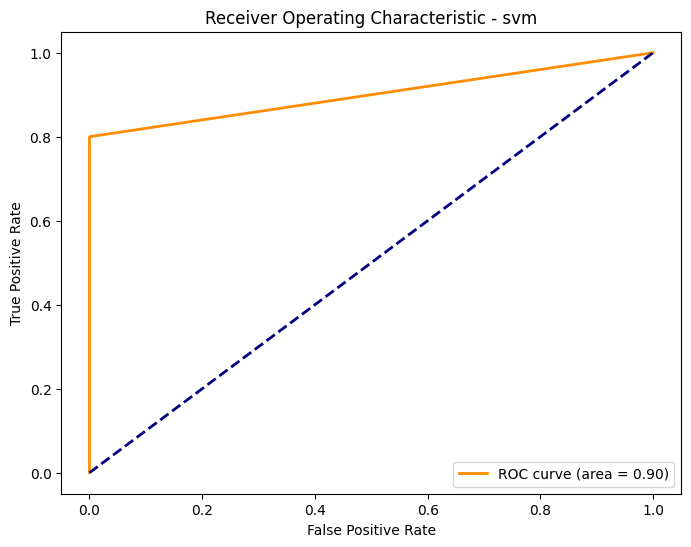

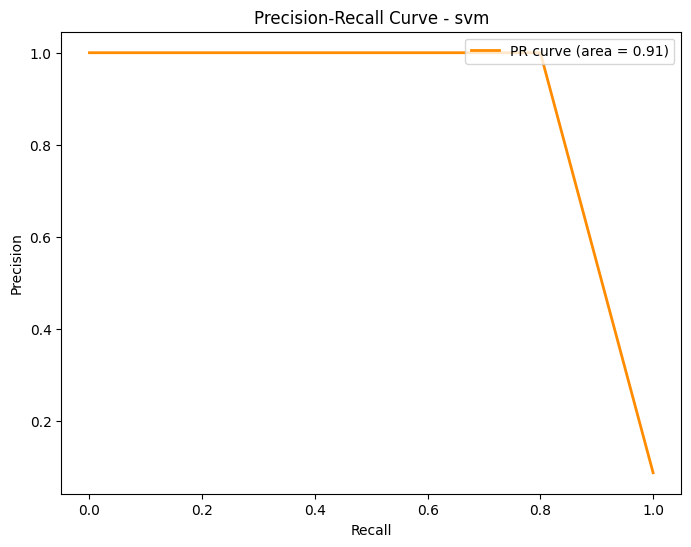

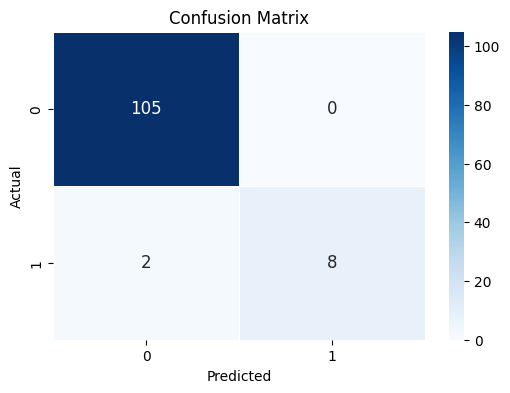

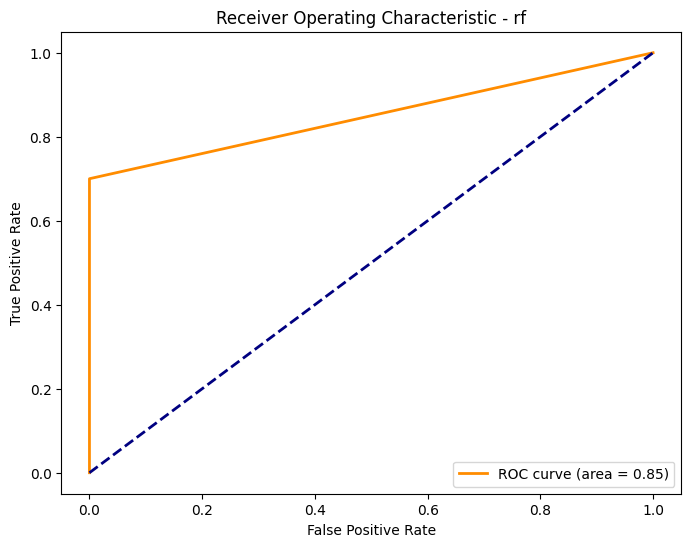

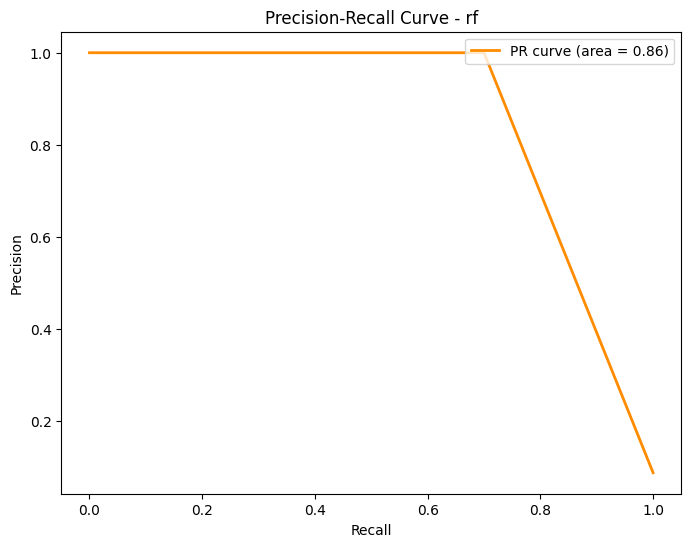

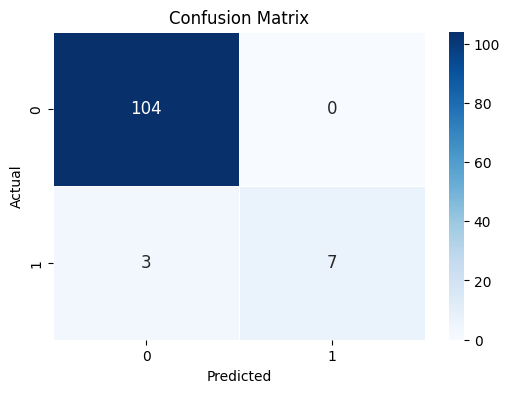

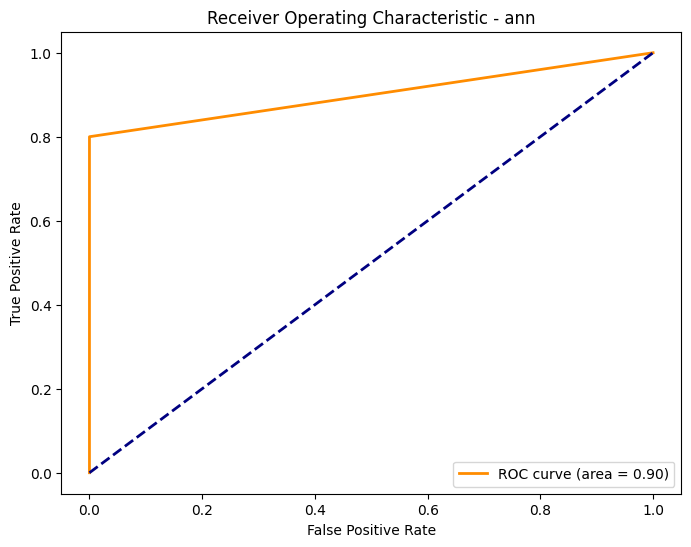

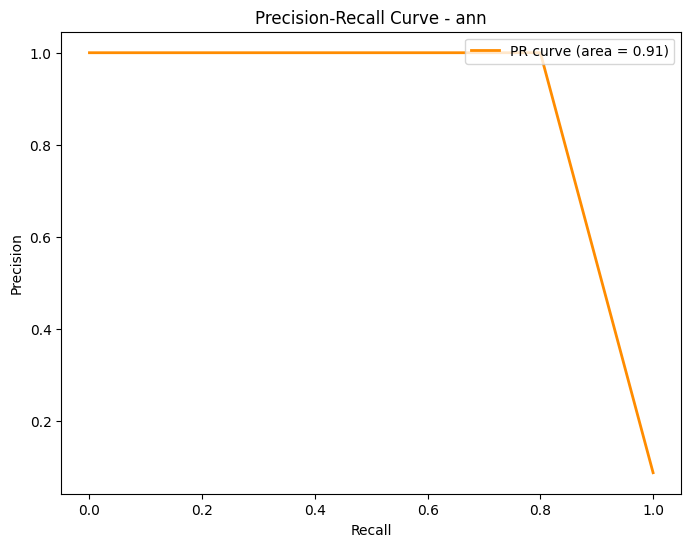

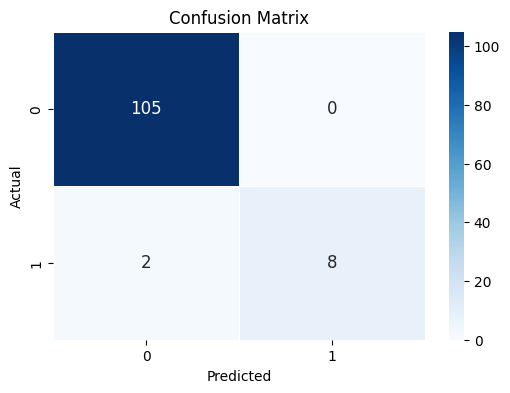

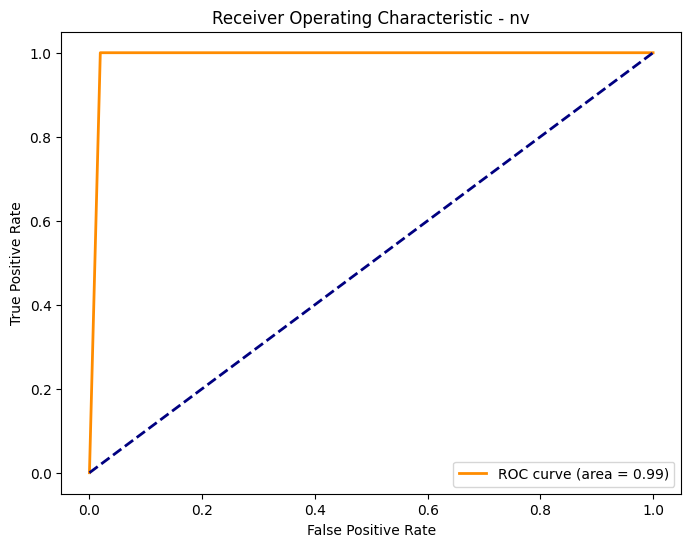

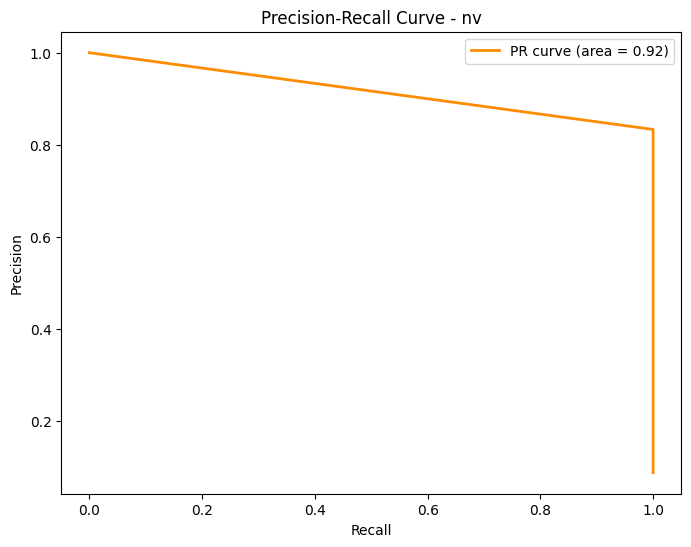

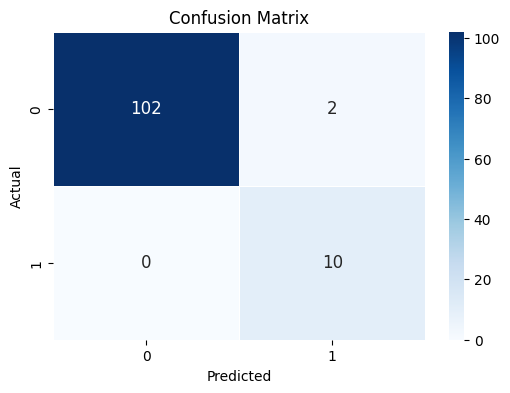

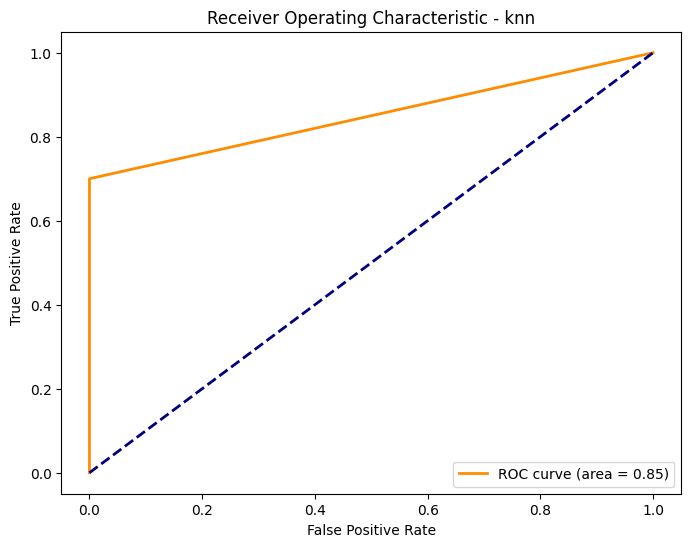

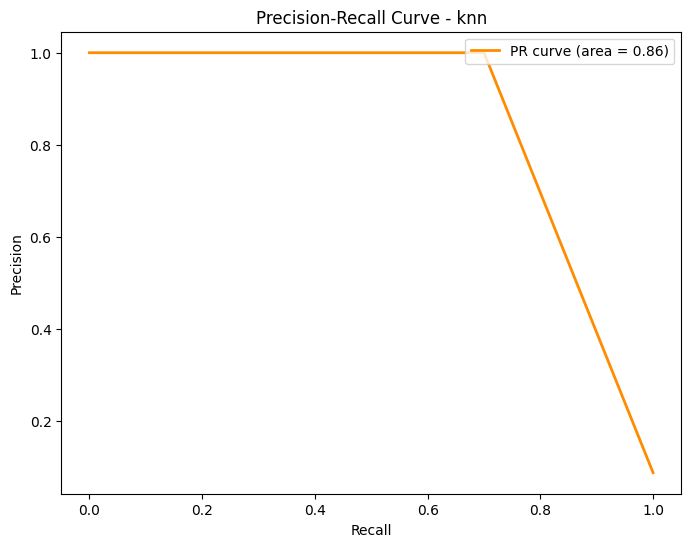

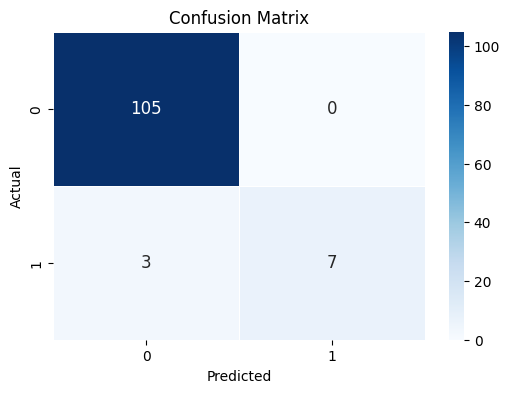

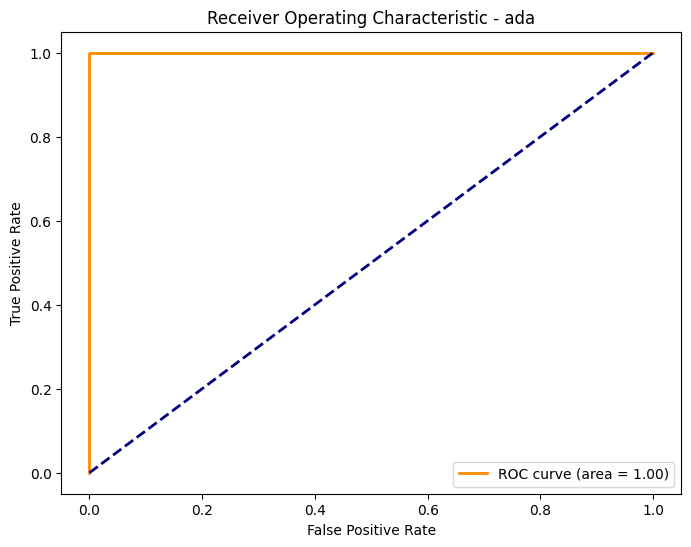

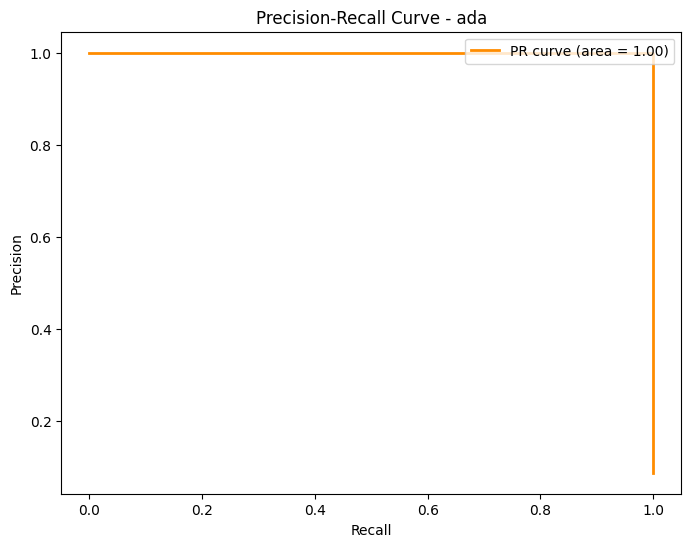

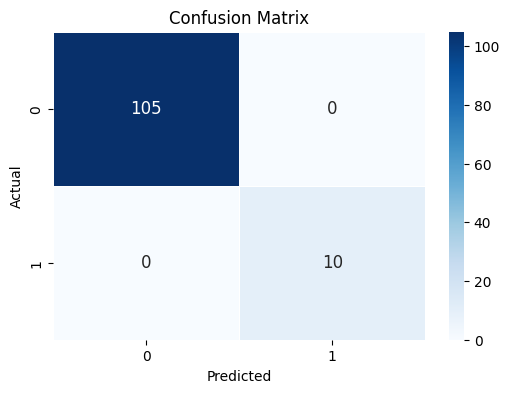

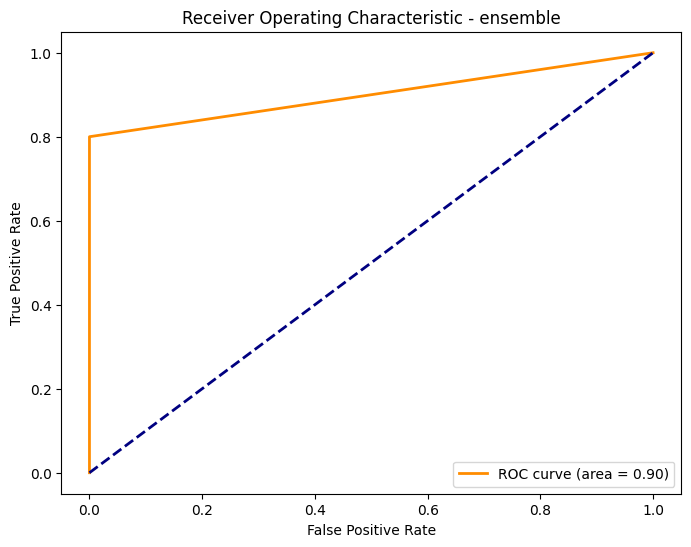

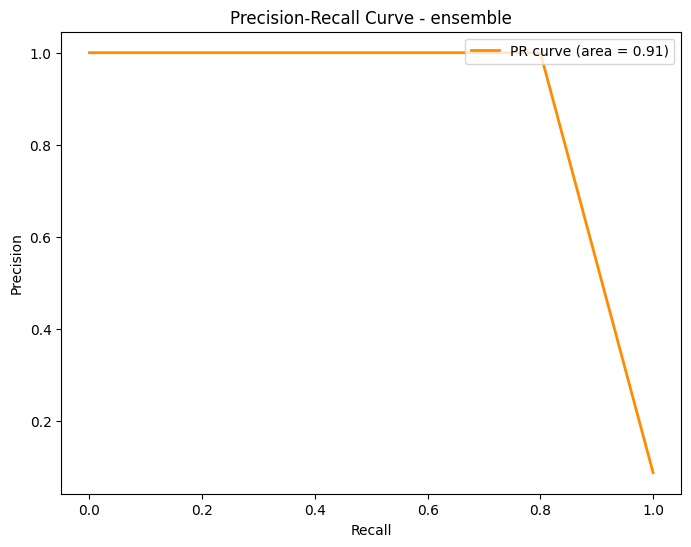

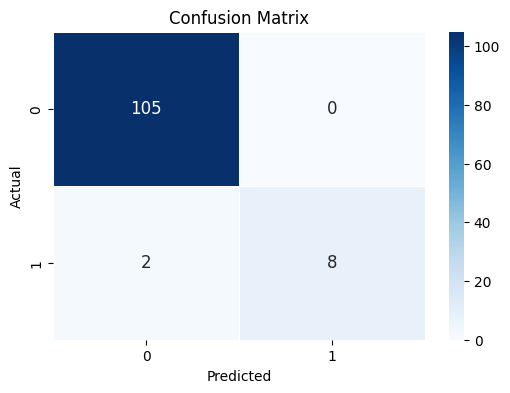

In [22]:
# Loop through classifiers and evaluate
scores = {}

for clf_name, clf in classifiers.items():
    selected_features = selected_features_map[clf_name]
    scores[clf_name] = evaluate_model(clf_name, clf, X_scaled[selected_features], y_data)

scores = pd.DataFrame(scores)

In [24]:
scores

,svm,rf,ann,nv,knn,ada,ensemble
Accuracy,0.958078,0.965927,0.969413,0.965057,0.960671,0.967666,0.967681
Precision,0.956465,0.965202,0.970293,0.969544,0.960265,0.967118,0.968438
Recall,0.958078,0.965927,0.969413,0.965057,0.960671,0.967666,0.967681
AUC,0.984189,0.987041,0.988532,0.976675,0.952239,0.981183,0.988738
F1 Score,0.954622,0.963936,0.969150,0.966394,0.957333,0.967031,0.965518
